In [1]:
import torch
import os
torch.cuda.current_device()

0

#### Now you can access your Google Drive account as a drive. You can download, upload, read, write or create files and folders here.

In [2]:
os.chdir('data')

## Code Starts here.

In [4]:
%matplotlib inline  
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
from matplotlib import style
import seaborn as sns

style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image
from sklearn.utils import shuffle
from efficientnet_pytorch import EfficientNet
import pretrainedmodels

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [6]:
seed_everything(42)

In [10]:
# ! chmod a+rwx prev_competition/*
base_image_dir1 = 'old_data/'
# os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir1 = os.path.join(base_image_dir1,'resized_train_cropped/')
df1 = pd.read_csv(os.path.join(base_image_dir1, 'trainLabels_cropped.csv'))
df1['path'] = df1['image'].map(lambda x: os.path.join(train_dir1,'{}.jpeg'.format(x)))
df1 = df1.drop(columns=['image', 'Unnamed: 0', 'Unnamed: 0.1'])
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle dataframe
df1.head(10)

,level,path
0,0,old_data/resized_train_cropped/17340_right.jpeg
1,0,old_data/resized_train_cropped/27852_right.jpeg
2,4,old_data/resized_train_cropped/34901_left.jpeg
3,0,old_data/resized_train_cropped/20070_right.jpeg
4,0,old_data/resized_train_cropped/20273_right.jpeg
5,0,old_data/resized_train_cropped/34769_left.jpeg
6,0,old_data/resized_train_cropped/24355_left.jpeg
7,0,old_data/resized_train_cropped/41537_right.jpeg
8,3,old_data/resized_train_cropped/7060_left.jpeg
9,4,old_data/resized_train_cropped/31006_left.jpeg


In [11]:
base_image_dir2 = 'new_data/'
# os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir2 = os.path.join(base_image_dir2,'train_images/')
df2 = pd.read_csv(os.path.join(base_image_dir2, 'train.csv'))
df2['path'] = df2['id_code'].map(lambda x: os.path.join(train_dir2,'{}.png'.format(x)))
df2 = df2.drop(columns=['id_code'])
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True) #shuffle dataframe
df2.columns = ['level', 'path']

df2.head(10)

,level,path
0,0,new_data/train_images/90960ddf4d14.png
1,1,new_data/train_images/4e0656629d02.png
2,3,new_data/train_images/3b018e8b7303.png
3,4,new_data/train_images/55eb405ec71e.png
4,0,new_data/train_images/207dd0487264.png
5,0,new_data/train_images/1d74c4713e21.png
6,0,new_data/train_images/eb175669d789.png
7,4,new_data/train_images/b49b2fac2514.png
8,2,new_data/train_images/4a44cc840ebe.png
9,2,new_data/train_images/d6283ded6aea.png


In [12]:
df = pd.concat([df1, df2], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe

df.head(10)

,level,path
0,0,old_data/resized_train_cropped/9913_right.jpeg
1,2,old_data/resized_train_cropped/24318_left.jpeg
2,0,old_data/resized_train_cropped/33005_right.jpeg
3,0,old_data/resized_train_cropped/36886_left.jpeg
4,2,old_data/resized_train_cropped/36027_left.jpeg
5,1,new_data/train_images/8fc09fecd22f.png
6,0,old_data/resized_train_cropped/9204_right.jpeg
7,0,old_data/resized_train_cropped/4203_right.jpeg
8,0,old_data/resized_train_cropped/4253_left.jpeg
9,0,new_data/train_images/5069feccd866.png


There are 38770 images


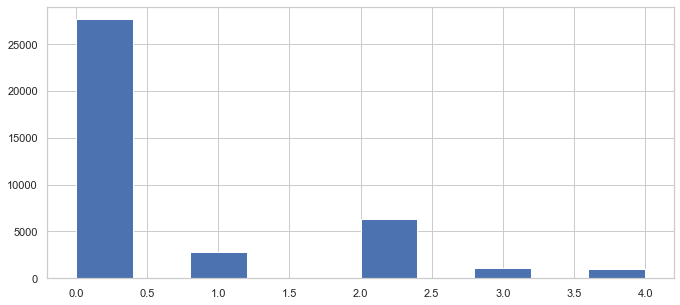

In [13]:
len_df = len(df)
# print(len(os.listdir('train_images')))
print(f"There are {len_df} images")
df['level'].hist(figsize = (10, 5))

819 614


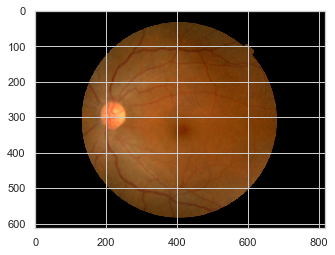

In [14]:
from PIL import Image
idx = 25407
# ! chmod a+rwx prev_competition/resized_train_cropped/*

# print(len(os.listdir('prev_competition/resized_train_cropped')))
path = 'new_data/train_images/f0e1201b5c1f.png'
# im = Image.open(df1['path'][idx])
im = Image.open(path)
width, height = im.size
print(width,height) 
im.show()
plt.imshow(np.asarray(im))
plt.show()

In [15]:
def crop_image_ilovescience(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print('no contours!')
        flag = 0
        return image, flag
    cnt = max(contours, key=cv2.contourArea)
    ((x, y), r) = cv2.minEnclosingCircle(cnt)
    x = int(x); y = int(y); r = int(r)
    flag = 1
    #print(x,y,r)
    if r > 100:
        return output[0 + (y-r)*int(r<y):-1 + (y+r+1)*int(r<y),0 + (x-r)*int(r<x):-1 + (x+r+1)*int(r<x)], flag
    else:
        print('none!')
        flag = 0
        return image,flag

(575, 574, 3)


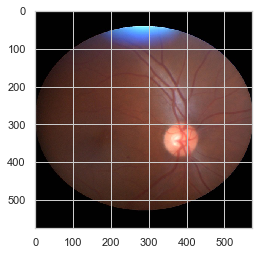

In [16]:
# img = cv2.imread(path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = crop_image_ilovescience((img/255.).astype('float32'))
path = 'new_data/test_images/d8468d108c02.png'
img, flag = crop_image_ilovescience(path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [17]:
# Batch size. Increase/Decrease upon GPU capacity
# Smaller batch size is better for training, but may take longer
bs = 12
# Image Dimension
sz= 256

In [18]:
from albumentations import *
import time


def show_image(image,figsize=None,title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
#     else: # crash!!
#         fig = plt.figure()
        
    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)

def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)

'''Use case from https://www.kaggle.com/alexanderliao/image-augmentation-demo-with-albumentation/'''
def albaugment(aug0, img):
    return aug0(image=img)['image']
# idx=8
# image1=image


def apply_album(img, sz):
    IMG_SIZE = (sz,sz)
    '''1. Rotate or Flip'''
    # aug1 = OneOf([
    #     Rotate(p=0.99, limit=160, border_mode=0, value=0), # value=black
    #     Flip(p=0.5)
    #     ],p=1)

    '''2. Adjust Brightness or Contrast'''
    # aug2 = RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45,p=1)
    # h_min=np.round(IMG_SIZE[1]*0.72).astype(int)
    # h_max= np.round(IMG_SIZE[1]*0.9).astype(int)
    # print(h_min,h_max)

    '''3. Random Crop and then Resize'''
    #w2h_ratio = aspect ratio of cropping
    # aug3 = RandomSizedCrop((h_min, h_max),IMG_SIZE[1],IMG_SIZE[0], w2h_ratio=IMG_SIZE[0]/IMG_SIZE[1],p=1)
    aug3 = CenterCrop(np.round(img.shape[0]*0.80).astype(int), np.round(img.shape[1]*0.80).astype(int))
    # print(np.round(img.shape[1]*0.80).astype(int), np.round(img.shape[0]*0.80).astype(int))
    '''4. CutOut Augmentation'''
    max_hole_size = int(IMG_SIZE[1]/10)
    aug4 = Cutout(p=1,max_h_size=max_hole_size,max_w_size=max_hole_size,num_holes=8 )#default num_holes=8
    # print(max_hole_size)
    '''5. SunFlare Augmentation'''
    aug5 = RandomSunFlare(src_radius=max_hole_size,
                        num_flare_circles_lower=1,
                        num_flare_circles_upper=3,
                        p=1)#default flare_roi=(0,0,1,0.5),

    '''6. Ultimate Augmentation -- combine everything'''
    final_aug = OneOf([
        # aug1,aug2,
        aug3
        # ,aug4, aug5
    ],p=0.5)

    return final_aug(image=img)['image']



In [19]:
def crop_image(img,tol=7):        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]


def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def open_aptos2019_image(fn, convert_mode, after_open)->Image:
    SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = crop_image(image)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0,0) , SIZE/10) ,-4 ,128)
    return Image(pil2tensor(image, np.float32).div_(255))
    
def load_ben_color(fn, convert_mode, after_open)->Image:
    sigmaX=10
    IMG_SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return Image(pil2tensor(image, np.float32).div_(255))

def load_ben_color_pre(fn, aug=True):
    sigmaX=10
    IMG_SIZE = sz
    try:
      image = cv2.imread(fn)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = crop_image_from_gray(image)
      if aug==True:
          image = apply_album(image, IMG_SIZE)
      image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
      image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
      return image
    except:
      print(fn)
      pass

def open_aptos2019_image_pre(fn):
    SIZE = sz
    image = cv2.imread(fn)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = crop_image(image)
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image , (0,0) , SIZE/10) ,-4 ,128)
    return image

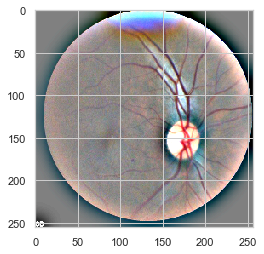

In [20]:
# preprocessed_img = load_ben_color_pre(df['path'][idx])
preprocessed_img = load_ben_color_pre(path)
plt.imshow(preprocessed_img)

In [21]:
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
#         img = load_ben_color_pre(fn.replace('/./','').replace('//','/'), aug=False)
        img, flag = crop_image_ilovescience(fn.replace('/./','').replace('//','/'))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32).div_(255))

In [18]:
val_idx = [i for i in range(len(df1), len(df))]

In [22]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=24)
print(skf.get_n_splits(df))
train_idx, val_idx = None, None
for train_index, test_index in skf.split(df, df['level']):
  train_idx, val_idx =  train_index, test_index
  break

10


# Phase 1 Training

In [23]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom= 1.2, max_lighting=0.5, p_lighting=0.5, p_affine=0.5)
src = (MyImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
#         .split_by_rand_pct(0.1) #Splitting the dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='level',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

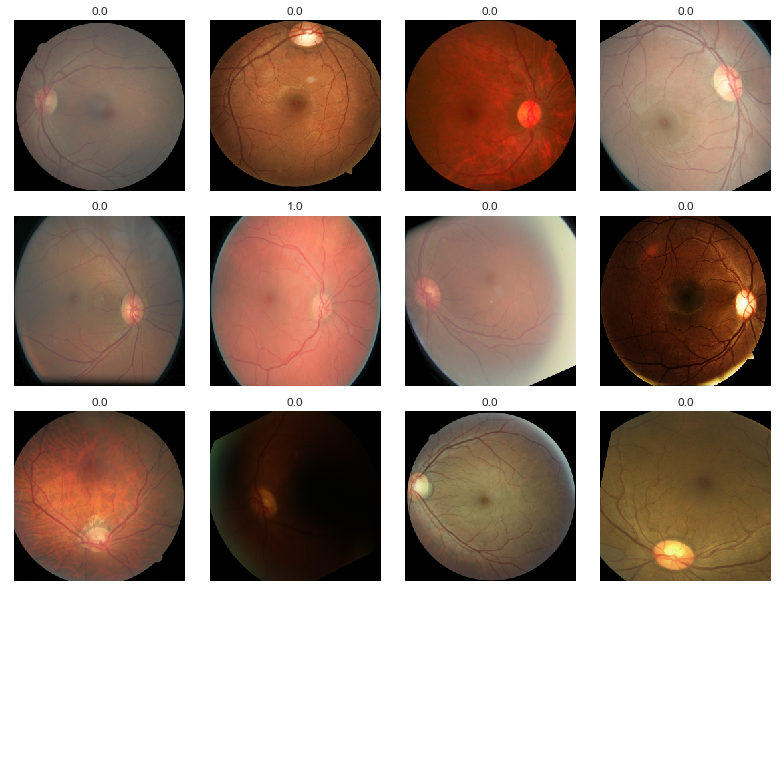

In [24]:
data.show_batch(rows=8, figsize=(11,11))

In [26]:
data

ImageDataBunch;

Train: LabelList (34891 items)
x: MyImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,2.0,2.0,2.0,2.0
Path: .;

Valid: LabelList (3879 items)
x: MyImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,2.0,0.0,0.0,2.0
Path: .;

Test: None

In [27]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

# EfficientNet

In [28]:
model_name = 'efficientnet-b0' # change b5 to b0-b4 for different versions of EfficientNet
model = EfficientNet.from_pretrained(model_name, num_classes=1)
learn = Learner(data, model, metrics = [quadratic_kappa], model_dir='models')

Loaded pretrained weights for efficientnet-b0


# Other Pretrained Models

In [0]:
def get_cadene_model(model_name='se_resnet101', pretrained=True):
    if pretrained:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    else:
        arch = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
    return arch

# Available Pretrained Models

In [0]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


### `Note`: If you've already choosen efficientnet as your model, don't run this section.

In [0]:
try:
    os.mkdir('/root/.cache/torch/')
except:
    pass
try:
    os.mkdir('/root/.cache/torch/checkpoints')
except:
    pass
! cp ../pretrainedmodels/resnext101_32x4d-29e315fa.pth /root/.cache/torch/checkpoints/resnext101_32x4d-29e315fa.pth

In [0]:
model_name = 'resnext101_32x4d' # You can choose any pretrained models from the list above
model = partial(get_cadene_model, model_name)
learn = cnn_learner(data, base_arch = model, metrics=[quadratic_kappa], model_dir='models')

In [0]:
# learn.data.batch_size = 10

## Learning Rate Finder for stage 1

We are going to find out suitable learning rate for our model to start training.

In [29]:
stage = 1
# learn.data.batch_size = 18

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-07
Min loss divided by 10: 3.63E-04


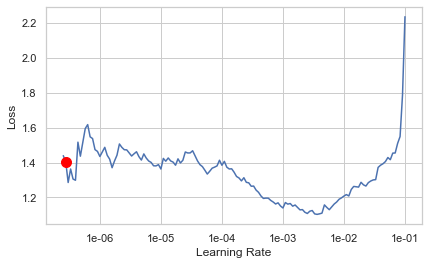

In [30]:
learn.lr_find(start_lr=1e-7, num_it=200, end_lr=10)
learn.recorder.plot(suggestion=True)

## Callbacks

In [31]:
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage)+'_'+model_name, append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                        monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)

## Training Stage 1

In [ ]:
lr = 5e-4 # Put your learning rate here.
learn.fit_one_cycle(5,max_lr = lr, callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time


In [24]:
import gc
gc.collect()

60

## Losses and Metrics

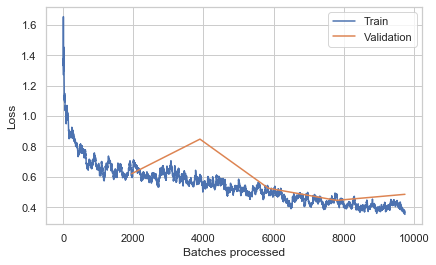

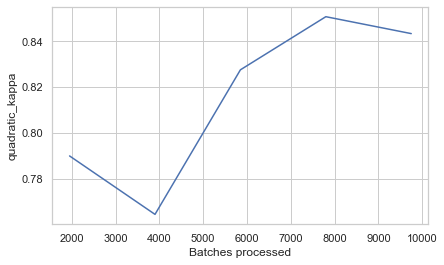

In [32]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

## Unfreeze model and Prepare for stage 2 training

In [25]:
# stage = 2
learn.load('stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse_2')
print(learn.summary())

EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 225, 225]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 112, 112]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 114, 114]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 112, 112]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 112, 112]       0          False     
_________________________________________________

In [26]:
stage = 2
learn.unfreeze()

## Learning Rate Finder for Stage 2 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.13E-07
Min loss divided by 10: 2.03E-05


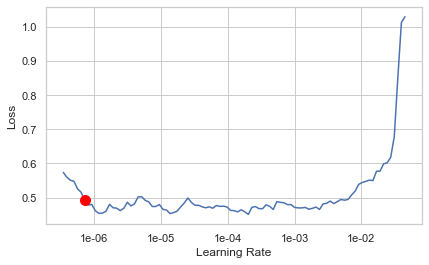

In [27]:
learn.lr_find(start_lr=1e-7, num_it=150, end_lr=10)
learn.recorder.plot(suggestion=True)

## Training Stage 2

In [ ]:
lr = 1e-3 #Put your learning rate here.  
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage), append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                         monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)
learn.fit_one_cycle(4,max_lr = slice(lr), callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.430239,0.490775,0.847472,1:14:33
1,0.416557,0.409743,0.851771,1:39:15
2,0.417712,0.538242,0.830834,56:01


In [28]:
lr = 1e-3 #Put your learning rate here.  
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage), append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                         monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)
learn.fit_one_cycle(4,max_lr = slice(lr), callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.539994,0.561632,0.792467,1:19:41
1,0.468021,0.508178,0.831705,56:57
2,0.446301,0.468688,0.848726,55:33
3,0.396906,0.492781,0.844448,54:41


In [29]:
lr = 1e-3 #Put your learning rate here.  
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_stage_'+str(stage), append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                         monitor='quadratic_kappa', mode='max',
                                        name='stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)
learn.fit_one_cycle(4,max_lr = slice(lr), callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.405443,0.465198,0.830083,1:36:44
1,0.462644,0.801269,0.745769,54:34
2,0.391008,0.546795,0.820028,1:06:06
3,0.389892,0.523918,0.838172,1:44:21


Epoch 2: reducing lr to 0.0001415304991043496


In [0]:
print('stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse_v2')
! mv models/stage_2_bestmodel_efficientnet-b2_256_mse_v2_5.pth models/stage_2_bestmodel_efficientnet-b2_256_mse.pth

stage_2_bestmodel_efficientnet-b2_256_mse_v2


## Losses and Metrics

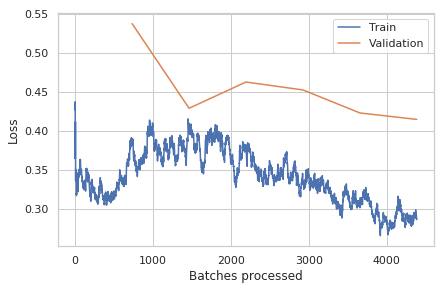

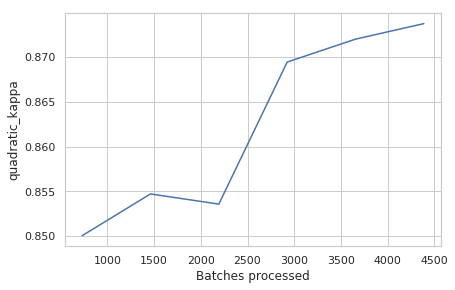

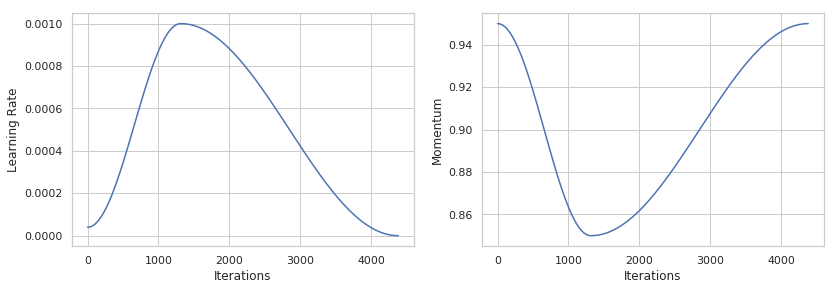

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.recorder.plot_lr(show_moms=True)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [0]:
interp.plot_top_losses(k=10)

AttributeError: ignored

## Choose the best model and load

In [0]:
stage = 2
best_model = 'stage_'+str(stage)+'_bestmodel_'+model_name+'_'+str(sz)+'_mse_4'
print(best_model)
# export_name = 'models/export_bestmodel_'+model_name+str(sz)+'_mse_0'
learn.load(best_model)
print(learn.summary())

stage_2_bestmodel_resnext101_32x4d_224_mse_4
Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [128, 56, 56]        8,192      False     
______________________________________________________________________
BatchNorm2d          [128, 56, 56]        256        True      
______________________________________________________________________
ReLU                 [128, 56, 56]        0          False     
______

# Phase 2 Training

In [0]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=24)
print(skf.get_n_splits(df2))
train_idx, val_idx = None, None
for train_index, test_index in skf.split(df2, df2['level']):
  train_idx, val_idx =  train_index, test_index
  break

5


In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.25,max_lighting=0.5,p_lighting=0.5, p_affine=0.5)
src = (MyImageItemList.from_df(df=df2,path='./',cols='path') #get dataset from dataset
        # .split_by_rand_pct(0.1) #Splitting the dataset
       .split_by_idx(val_idx)
        .label_from_df(cols='level',label_cls=FloatList) #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

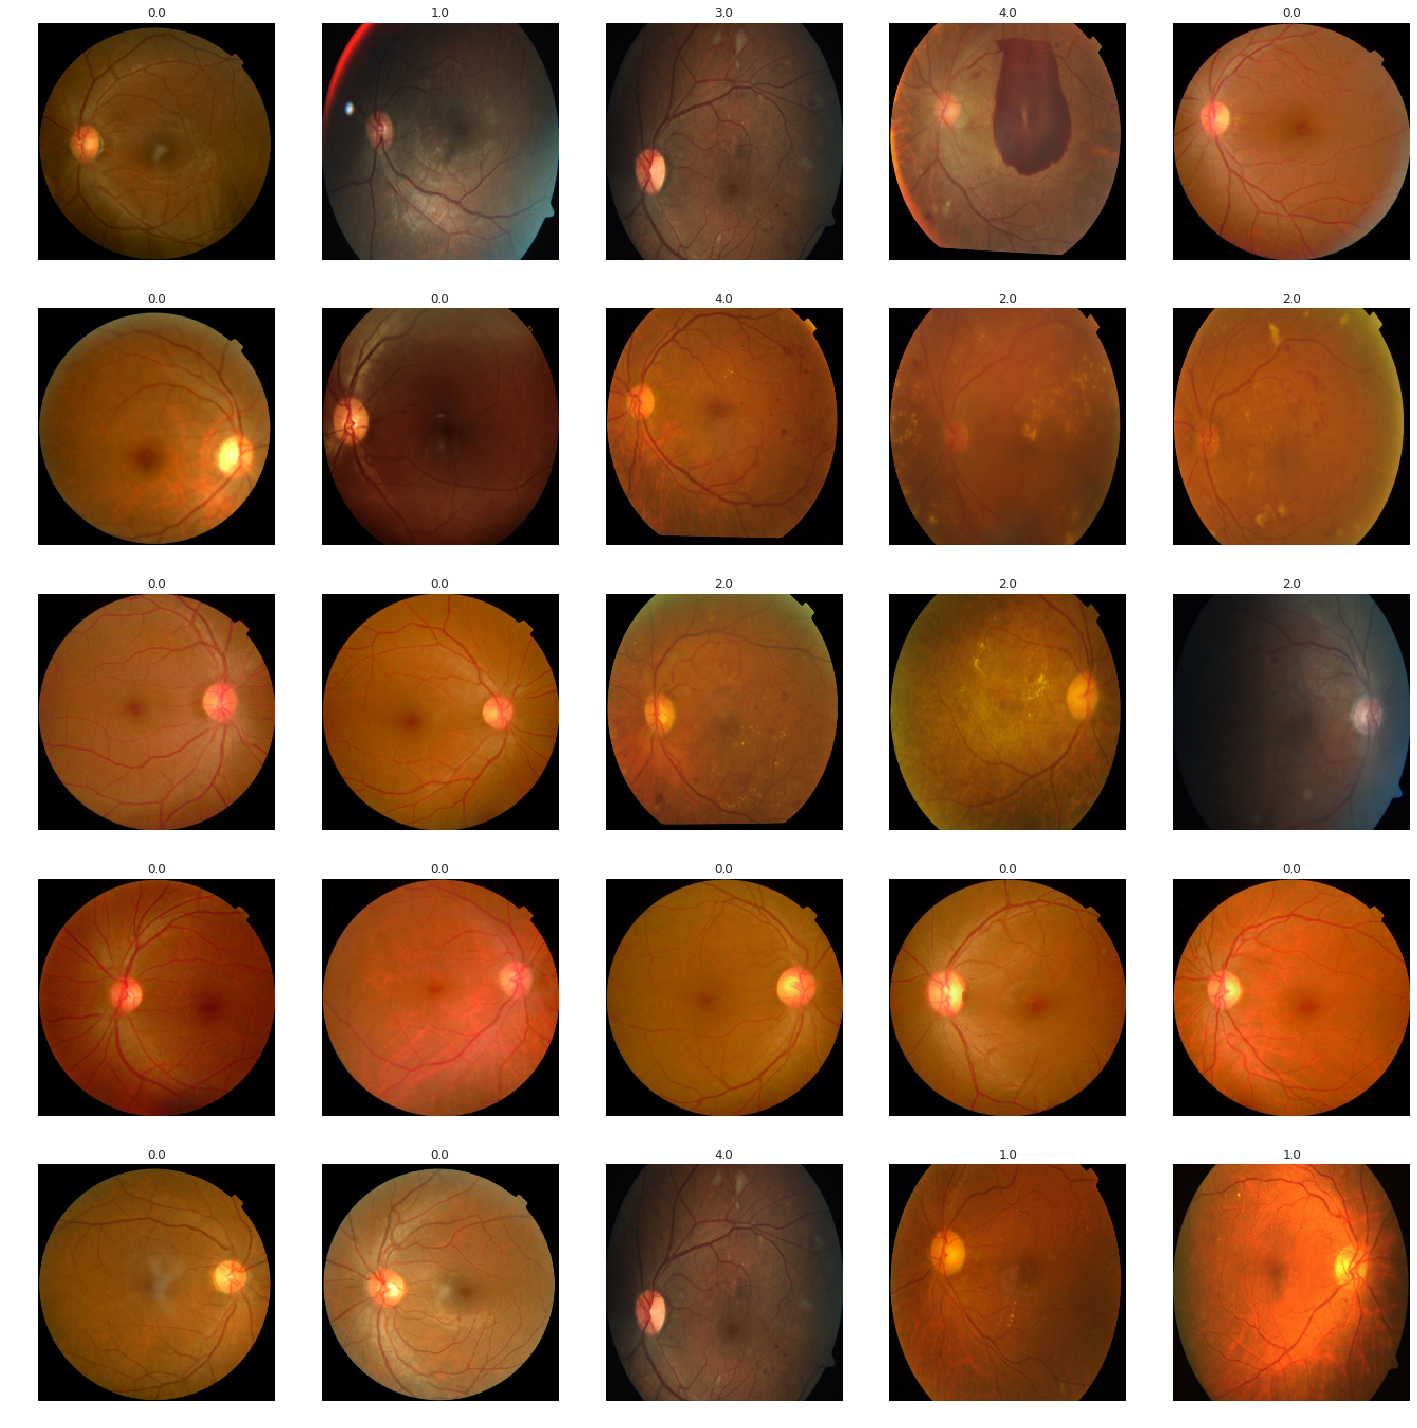

In [0]:
data.show_batch(ds_type= DatasetType.Valid)

In [0]:
# stage = 2
learn = Learner(data, model, metrics = [quadratic_kappa], model_dir='models') # For Efficientnet
# model = partial(get_cadene_model, model_name)
# learn = cnn_learner(data, base_arch = model, metrics=[quadratic_kappa], model_dir='models')

In [0]:
# learn.load('stage_2_bestmodel_efficientnet-b5_320_mse')
# learn.load('stage_2_bestmodel_'+model_name+'_'+str(sz)+'_mse_v2_1')
best_model = 'stage_2_bestmodel_efficientnet-b2_256_mse'
print(best_model)
learn.load(best_model)
print(learn.summary())


stage_2_bestmodel_efficientnet-b2_256_mse
EfficientNet
Layer (type)         Output Shape         Param #    Trainable 
ZeroPad2d            [3, 257, 257]        0          False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
ZeroPad2d            [32, 130, 130]       0          False     
______________________________________________________________________
BatchNorm2d          [32, 128, 128]       64         True      
______________________________________________________________________
Identity             [32, 1, 1]           0          False     
______________________________________________________________________
Identity             [8, 1, 1]            0          False     
______________________________________________________________________
Identity             [32, 128, 128]       0          False     
_______

In [0]:
csvlogger = callbacks.CSVLogger(learn=learn, filename='history_phase2'+model_name+'_'+str(sz), append=True)
saveModel = callbacks.SaveModelCallback(learn, every='epoch',
                                        monitor='quadratic_kappa', mode='max',
                                        name='bestmodel_'+model_name+'_'+str(sz)+'_mse_p2')
reduceLR = callbacks.ReduceLROnPlateauCallback(learn=learn, monitor = 'quadratic_kappa', mode = 'max', patience = 1, factor = 0.5)

In [0]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.17E-06
Min loss divided by 10: 6.31E-04


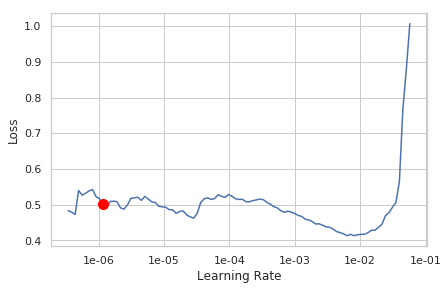

In [0]:
learn.lr_find(start_lr=1e-7, num_it=150, end_lr = 10)
learn.recorder.plot(suggestion=True)

In [0]:
lr = 1e-3
learn.fit_one_cycle(10, max_lr=slice(lr), callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time


In [0]:
learn.fit_one_cycle(4, max_lr=1e-4, callbacks=[csvlogger, saveModel, reduceLR])

epoch,train_loss,valid_loss,quadratic_kappa,time
0,0.263550,0.226888,0.916616,10:49
1,0.257634,0.233848,0.906324,11:05
2,0.256333,0.230013,0.911816,11:07
3,0.252438,0.227689,0.914329,10:53


Epoch 2: reducing lr to 1.407914165269455e-05


In [0]:
learn.load('bestmodel_'+model_name+'_'+str(sz)+'_mse_p2_v2_0')

Learner(data=ImageDataBunch;

Train: LabelList (2929 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
4.0,4.0,2.0,2.0,4.0
Path: .;

Valid: LabelList (733 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: FloatList
0.0,1.0,3.0,4.0,0.0
Path: .;

Test: LabelList (1928 items)
x: MyImageItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: ., model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Sequential(
   

In [0]:
print('bestmodel_'+model_name+'_'+str(sz)+'_mse_p2_v2_0')
! mv models/bestmodel_resnext101_32x4d_224_mse_p2_v2_0.pth models/bestmodel_resnext101_32x4d_224_mse_p2_v2_783.pth

bestmodel_resnext101_32x4d_224_mse_p2_v2_0


## Predictions

In [0]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [0]:
sample_df = pd.read_csv('sample_submission.csv')
sample_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


In [0]:
learn.data.add_test(MyImageItemList.from_df(sample_df,'./',folder='test_images',suffix='.png'))
# data.show_batch(ds_type=DatasetType.Test)
# learn2.data.add_test(MyImageItemList.from_df(sample_df,'./',folder='test_images',suffix='.png'))

# learn3.data.add_test(MyImageItemList.from_df(sample_df,'./',folder='test_images',suffix='.png'))
# data.show_batch(rows = 7, ds_type=DatasetType.Test)

In [0]:
preds,y, loss = learn.get_preds(with_loss=True, DatasetType.Valid)
preds,y = learn.get_preds(DatasetType.Test)
# preds2,y2 = learn2.get_preds(DatasetType.Test)
# preds3,y3 = learn3.get_preds(DatasetType.Test)
# acc = [0.763, 0.778, 0.781]
# preds = preds1*acc[0] + preds2*acc[1] + preds3*acc[2]
# # print(sum(i for i in acc))
# preds /= sum(i for i in acc)

coefficients = [0.5, 1.5, 2.5, 3.5]
optR = OptimizedRounder()
test_predictions = optR.predict(preds, coefficients)

In [0]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head(20)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


In [0]:
sample_df.to_csv('submission.csv',index=False)

In [0]:
d = open('submission.csv').read()
d

'id_code,diagnosis\n0005cfc8afb6,1\n003f0afdcd15,2\n006efc72b638,3\n00836aaacf06,2\n009245722fa4,2\n009c019a7309,2\n010d915e229a,3\n0111b949947e,0\n01499815e469,3\n0167076e7089,0\n01c31b10ab99,1\n01c5ba195207,3\n01e4d86b3a30,2\n020921b796d5,2\n020f6983114d,2\n021c207614d6,2\n0229c0a80d42,2\n024d0a225db1,2\n0268f4382c67,3\n0299d97f31f7,1\n03042a663e54,2\n030e06ddbb04,2\n033cdbbbdfaa,2\n03be80919be4,3\n03eaa4eef484,2\n0434995d0654,0\n04a0773c71fb,2\n04e1b77ef107,2\n051d9d12a6ee,2\n052e00f47cfa,2\n06035cfbcc18,0\n061e7dab2b76,2\n0622a0f615db,2\n062ed40f5272,1\n0654cdd3c01a,2\n065cb18bb0b2,2\n069037e82135,2\n069ebdb1023d,2\n06cdd3f3f262,0\n06daa7390238,3\n06e60df1823e,3\n0737dfb0a164,2\n0749255f718d,2\n07685fac659a,3\n079e029f3b2e,1\n07d8d154e752,3\n081c7ec32f27,2\n082c7ccb536a,3\n082fc6f323a1,1\n086727c22b75,2\n087966da55c2,3\n08a5afa9d62c,1\n08cfae721bd8,0\n08dc27511636,0\n0904fcd03369,3\n0928150bb29a,0\n0946ae407745,1\n0952ca2ece1c,2\n096d6bb6546b,2\n097614f1dcae,2\n09855c888f9f,2\n09b5

In [0]:
# del learn_test
print(gc.collect())

21
